In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '/content/drive/MyDrive/용훈/Data Analysis/ab_test/ab_testing_kaggle2/AB_Test_Results.csv'
df = pd.read_csv(path)
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


- VARIANT_NAME
  - CONTROL: 대조군
  - VARIANT: 실험군
- REVENUE: 수익(매출)

In [4]:
# Get dataset info
df.info()

# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


,0
USER_ID,0
VARIANT_NAME,0
REVENUE,0


- .nunique() : 고유한 값의 개수를 반환
- .unique(): 고유한 값을 리스트로 반환

In [5]:
df.nunique()

,0
USER_ID,6324
VARIANT_NAME,2
REVENUE,101


In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

,count
VARIANT_NAME,
1,4783
2,1541


올바른 A/B 테스트를 위해 각 사용자는 하나의 VARIANT_NAME만 가져야 한다.

하지만 현재 위 결과를 봤을 때 'CONTROL'과 'VARIANT' 둘 다 있는 사용자가 1541명이 있다는 것을 확인할 수 있다.

In [8]:
double_variant_count / double_variant_count.sum()

,count
VARIANT_NAME,
1,0.756325
2,0.243675


VARIANT_NAME을 한 개 가지고 있는 그룹: 약 76%

VARIANT_NAME을 두 개 가지고 있는 그룹: 약 24%

두 집단에 속한 사용자의 수가 24%로 상당히 많다는 것을 알 수 있다.

이러한 사용자는 실험에서의 변화 효과를 흐릴 수 있으므로 제거한다.

In [9]:
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
print(single_variant_users)


USER_ID
2         True
3        False
4         True
5         True
6         True
         ...  
9993      True
9995      True
9996     False
9998      True
10000    False
Name: VARIANT_NAME, Length: 6324, dtype: bool


In [10]:
single_variant_users = single_variant_users[single_variant_users]
single_variant_users

,VARIANT_NAME
USER_ID,
2,True
4,True
5,True
6,True
9,True
...,...
9990,True
9992,True
9993,True


In [11]:
single_variant_users.index

Index([   2,    4,    5,    6,    9,   11,   12,   13,   15,   19,
       ...
       9976, 9980, 9983, 9986, 9989, 9990, 9992, 9993, 9995, 9998],
      dtype='int64', name='USER_ID', length=4783)

In [12]:
unique_variant_df = df[df['USER_ID'].isin(single_variant_users.index)]
unique_variant_df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [13]:
unique_variant_df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

,count
VARIANT_NAME,
1,4783


## EDA

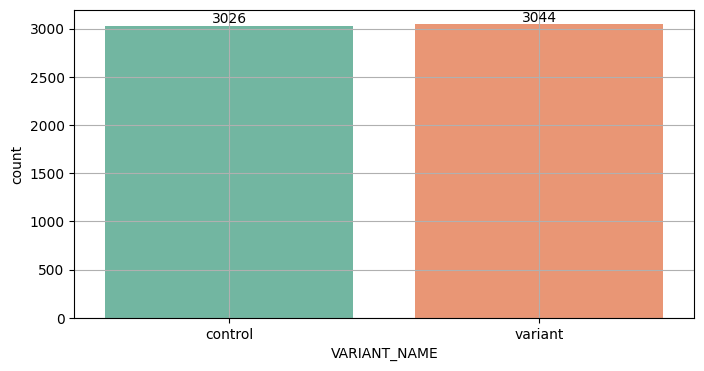

In [14]:
plt.figure(figsize=(8, 4))

ax1 = sns.countplot(x='VARIANT_NAME', data=unique_variant_df, palette='Set2', order=['control', 'variant'])
for container in ax1.containers:
    ax1.bar_label(container)

plt.grid()
plt.show()

variant(실험군)과 control(대조군)이 적절히 분리되어 있는 것을 확인할 수 있다.

## 가설 설정
- 귀무가설(H0): 실험군의 수익 == 대조군 수익
- 대립가설(H1): 실험군의 수익 > 대조군 수익

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

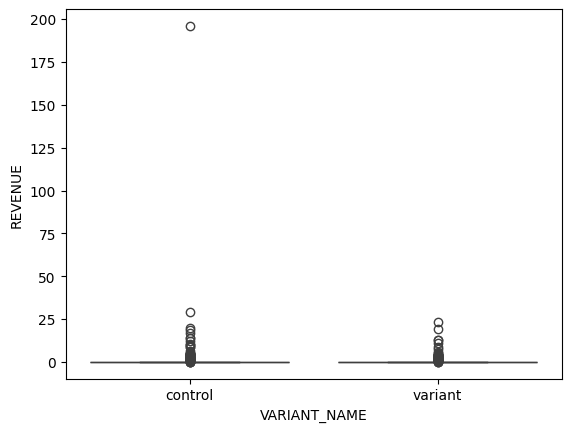

In [15]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=unique_variant_df, order=['control', 'variant'])

Boxplot의 결과 대조군에 이상치가 있는 것을 확인할 수 있다.

통계적 신뢰성과 실험 해석력을 확보 이상치를 제거한다.

In [16]:
unique_variant_df.sort_values(by='REVENUE', ascending=False).iloc[:5]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [17]:
unique_variant_df = unique_variant_df[unique_variant_df['USER_ID'] != 3342]
unique_variant_df[unique_variant_df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE


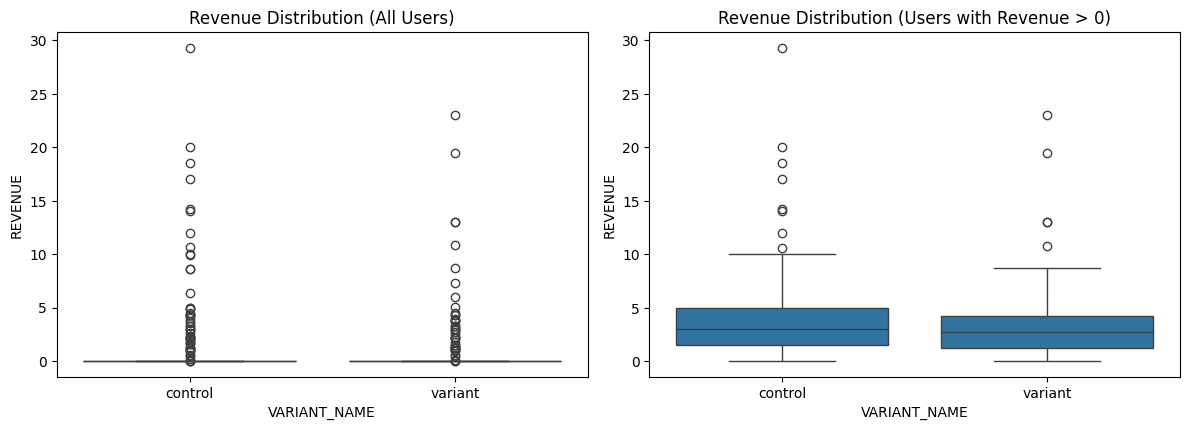

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=unique_variant_df, order=['control', 'variant'])
plt.title('Revenue Distribution (All Users)')


plt.subplot(2, 2, 2)
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=unique_variant_df[unique_variant_df['REVENUE'] > 0], order=['control', 'variant'])
plt.title('Revenue Distribution (Users with Revenue > 0)')

plt.tight_layout()
plt.show()

왼쪽 그래프를 봤을 때 사용자의 대부분이 구매가 없다.

구매한 적인 있는 사람의 평균은 대조군이 더 높은 것으로 확인된다.

여기서 user_id가 2번 이상 나오는 사용자가 있는지 확인해보자.

In [19]:
unique_variant_df.groupby(by=['USER_ID']).count().sort_values(by='VARIANT_NAME', ascending=False)[:10]

,VARIANT_NAME,REVENUE
USER_ID,,
5652,6,6
1782,5,5
1339,5,5
4919,4,4
6414,4,4
9396,4,4
1184,4,4
9152,4,4
1621,4,4


확인 결과 데이터에 여러 번 등록된 사용자를 찾을 수 있다.

즉, 행의 수는 사용자의 서비스 방문 횟수이다.

그러므로 사용자 별로 데이터를 그룹화하여 수익을 합산 데이터로 진행한다.

In [20]:
group_by_users = unique_variant_df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()
group_by_users

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4777,9990,variant,0.0
4778,9992,control,0.0
4779,9993,control,0.0
4780,9995,variant,0.0


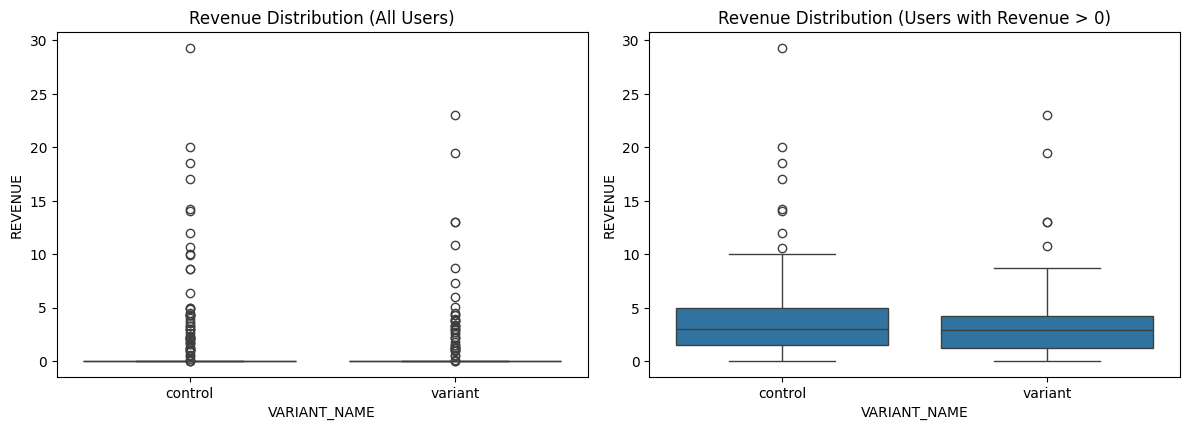

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=group_by_users, order=['control', 'variant'])

plt.title('Revenue Distribution (All Users)')


plt.subplot(2, 2, 2)
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=group_by_users[group_by_users['REVENUE'] > 0], order=['control', 'variant'])
plt.title('Revenue Distribution (Users with Revenue > 0)')

plt.tight_layout()
plt.show()

사용자 별로 데이터를 그룹화하였을 때 실험군의 사분위수가 증가했다는 점을 알 수 있다.

그래도 실험군이 대조군에 비해 최소값을 제외한 모든 사분위수 통계가 조금 낮은 수준임을 알 수 있다.

In [22]:
group_by_users

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4777,9990,variant,0.0
4778,9992,control,0.0
4779,9993,control,0.0
4780,9995,variant,0.0


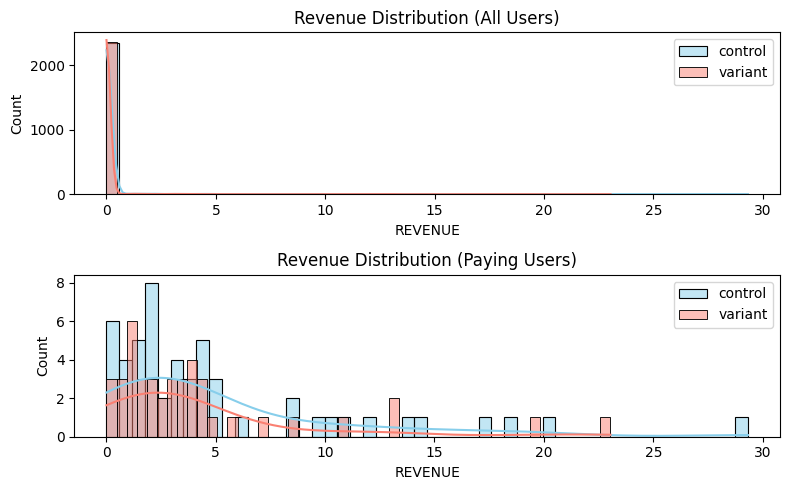

In [23]:
plt.figure(figsize=(8, 5))

# 1. 전체 사용자 수익 분포
plt.subplot(2, 1, 1)
sns.histplot(data=group_by_users[group_by_users['VARIANT_NAME'] == 'control'], x='REVENUE', kde=True, label='control', color='skyblue', bins=50)
sns.histplot(data=group_by_users[group_by_users['VARIANT_NAME'] == 'variant'], x='REVENUE', kde=True, label='variant', color='salmon', bins=50)
plt.title('Revenue Distribution (All Users)')
plt.legend()

# 2. 유료 사용자만 분포
plt.subplot(2, 1, 2)
sns.histplot(data=group_by_users[(group_by_users['VARIANT_NAME'] == 'control') & (group_by_users['REVENUE'] > 0)], x='REVENUE', kde=True, label='control', color='skyblue', bins=50)
sns.histplot(data=group_by_users[(group_by_users['VARIANT_NAME'] == 'variant') & (group_by_users['REVENUE'] > 0)], x='REVENUE', kde=True, label='variant', color='salmon', bins=50)
plt.title('Revenue Distribution (Paying Users)')
plt.legend()

plt.tight_layout()
plt.show()

두 집단 모두 정규분포를 따르지 않고 두 집단의 수익의 차이가 있는지 판단 해야되기 때문에 Mann–Whitney U검정을 실시한다.



In [24]:
from scipy.stats import ttest_ind

control_data = df[df['VARIANT_NAME'] == 'control']['REVENUE']
variant_data = df[df['VARIANT_NAME'] == 'variant']['REVENUE']

# t_stat, p_value = ttest_ind(control_data, variant_data, equal_var=False)

# print(f"T-statistic: {t_stat}")
# print(f"P-value: {p_value}")

In [25]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(control_data, variant_data, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

U-statistic: 12521564.0
P-value: 0.47825247965294926


## 가설 설정

귀무가설(H0): 실험군의 수익 == 대조군 수익

대립가설(H1): 실험군의 수익 > 대조군 수익


# 최종 결론
p-value가 0.05 이상이기 때문에 귀무가설을 기각하지 못한다.

즉, 통계적으로 유의미한 결과를 가지지 못하므로 실험군과 대조군의 수익성 차이는 없다.